In [1]:

# set connection parameters
UCM_PUBLISHER = 'us-cm-pub.ent-pa.com'
AXL_USER = 'administrator'
AXL_PASSWORD = '**********'

# from connection_parameters import *

# Using [Zeep](https://github.com/mvantellingen/python-zeep)

Zeep is a SOAP client for Python. Zeep inspects the WSDL document and generates the corresponding code to use the services and types in the WSDL document. This provides an easy to use programmatic interface to a SOAP server.

The output below has been created usigng 




In [2]:
import requests
import os
import zeep
import zeep.cache
import zeep.plugins
import zeep.exceptions
import urllib3
from lxml import etree

# a simple zeep plugin to log all SOAP request and responses to stdin
# a zeep plugin basically has two methods ingress and egress which get called just before sending (egress)
# and just after receiving (ingress) a SOAP request/response
class LoggingPlugin(zeep.plugins.Plugin):
    @staticmethod
    def print_envelope(header, envelope):
        s = etree.tostring(envelope, pretty_print=True).decode().strip()
        print('\n'.join(f'{header}:{l}' for l in s.splitlines()))

    def ingress(self, envelope, http_headers, operation):
        LoggingPlugin.print_envelope('in', envelope)
        return envelope, http_headers

    def egress(self, envelope, http_headers, operation, binding_options):
        LoggingPlugin.print_envelope('out', envelope)
        return envelope, http_headers
    
# disable warnings for HTTPS sessions w/ diabled cert validation
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

axl_url = f'https://{UCM_PUBLISHER}:8443/axl/'

# we have WSDL files for a number of releases in the WSDL directory
wsdl_version = '11.5'
wsdl = os.path.join('WSDL', wsdl_version, 'AXLAPI.wsdl')
print(f'Using WSDL: {wsdl}')

# we want to use the same requests session for all requests
# among other things this makes sure that cookies are handled
# properly: a sessoon cookies set by UCM in the 1st reaponse 
# will automatically be sent with each following request
# see: 
# https://developer.cisco.com/docs/axl/#!axl-developer-guide/using-jsessionidsso-to-improve-performance
session = requests.Session()
session.auth = (AXL_USER, AXL_PASSWORD)
session.verify = False

# setting up the zeep client
# - we enable the history plugin so that after calling an endpoint we have access to the latest request & response
# - also we enable our logging plugin above which logs requests and responses in real-time
transport = zeep.Transport(session=session, cache=zeep.cache.SqliteCache())
history = zeep.plugins.HistoryPlugin()
client = zeep.Client(wsdl=wsdl,
                     transport=transport,
                     # create a chain of plugins to keep the history of request/response
                     # and log everything to stdout
                     plugins=[history, LoggingPlugin()])
# the 1st parameter here is the binding defined in the WSDL
service = client.create_service('{http://www.cisco.com/AXLAPIService/}AXLAPIBinding', axl_url)


Using WSDL: WSDL/11.5/AXLAPI.wsdl


This service can now be used to call any method defined in the WSDL. For example the listCss is defined as:
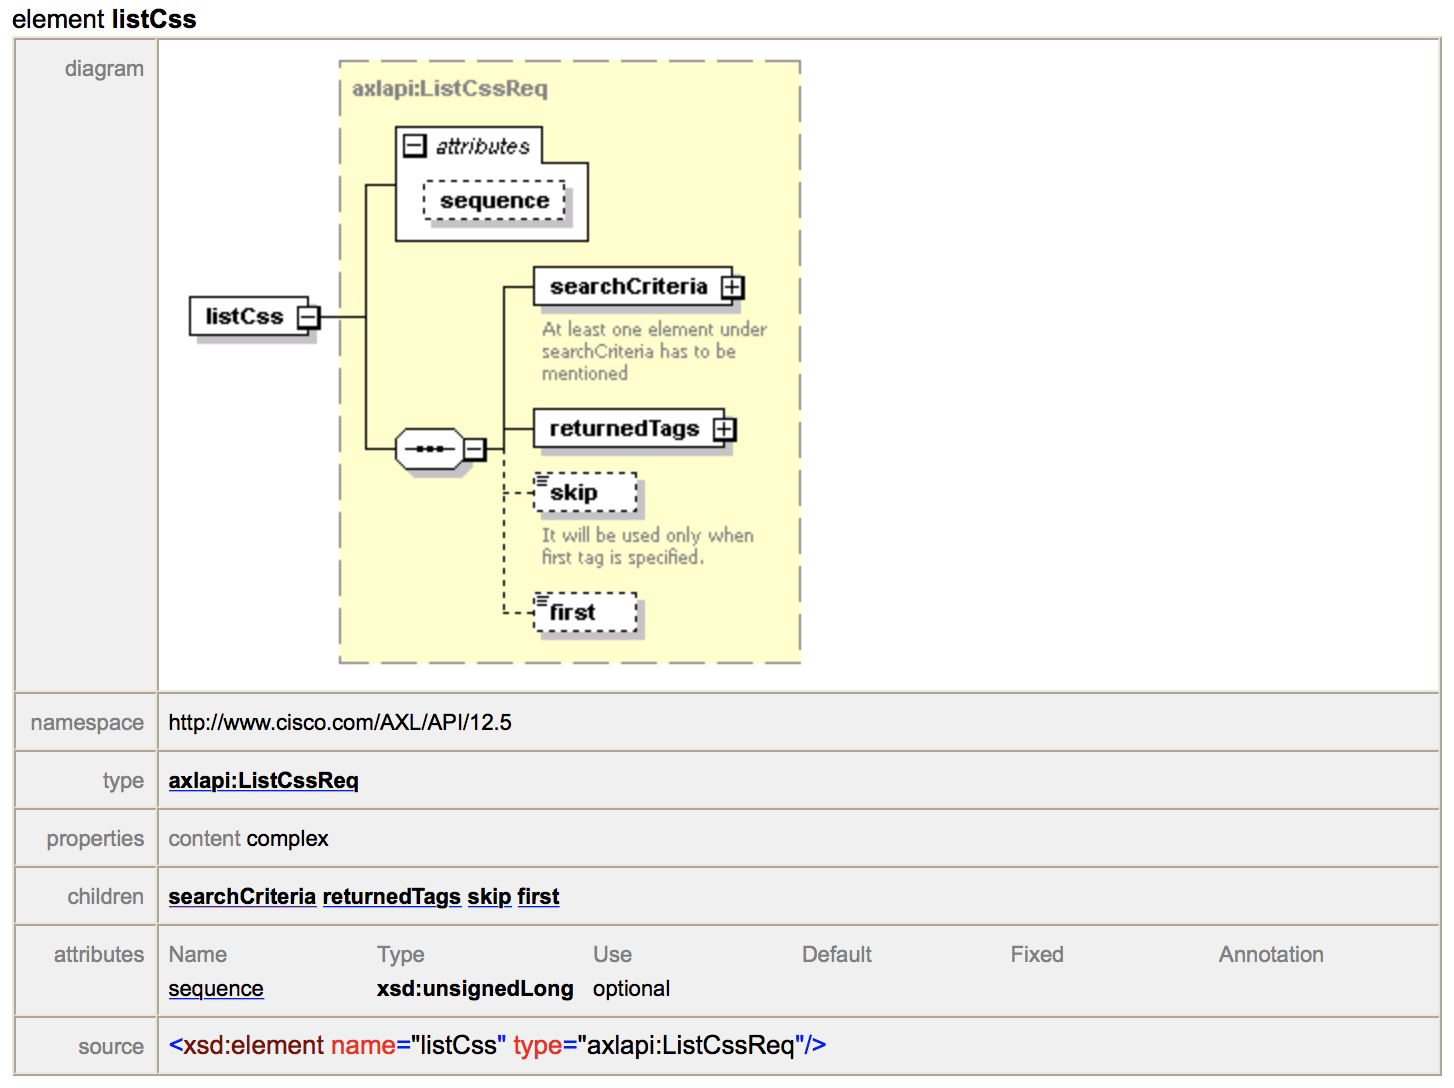
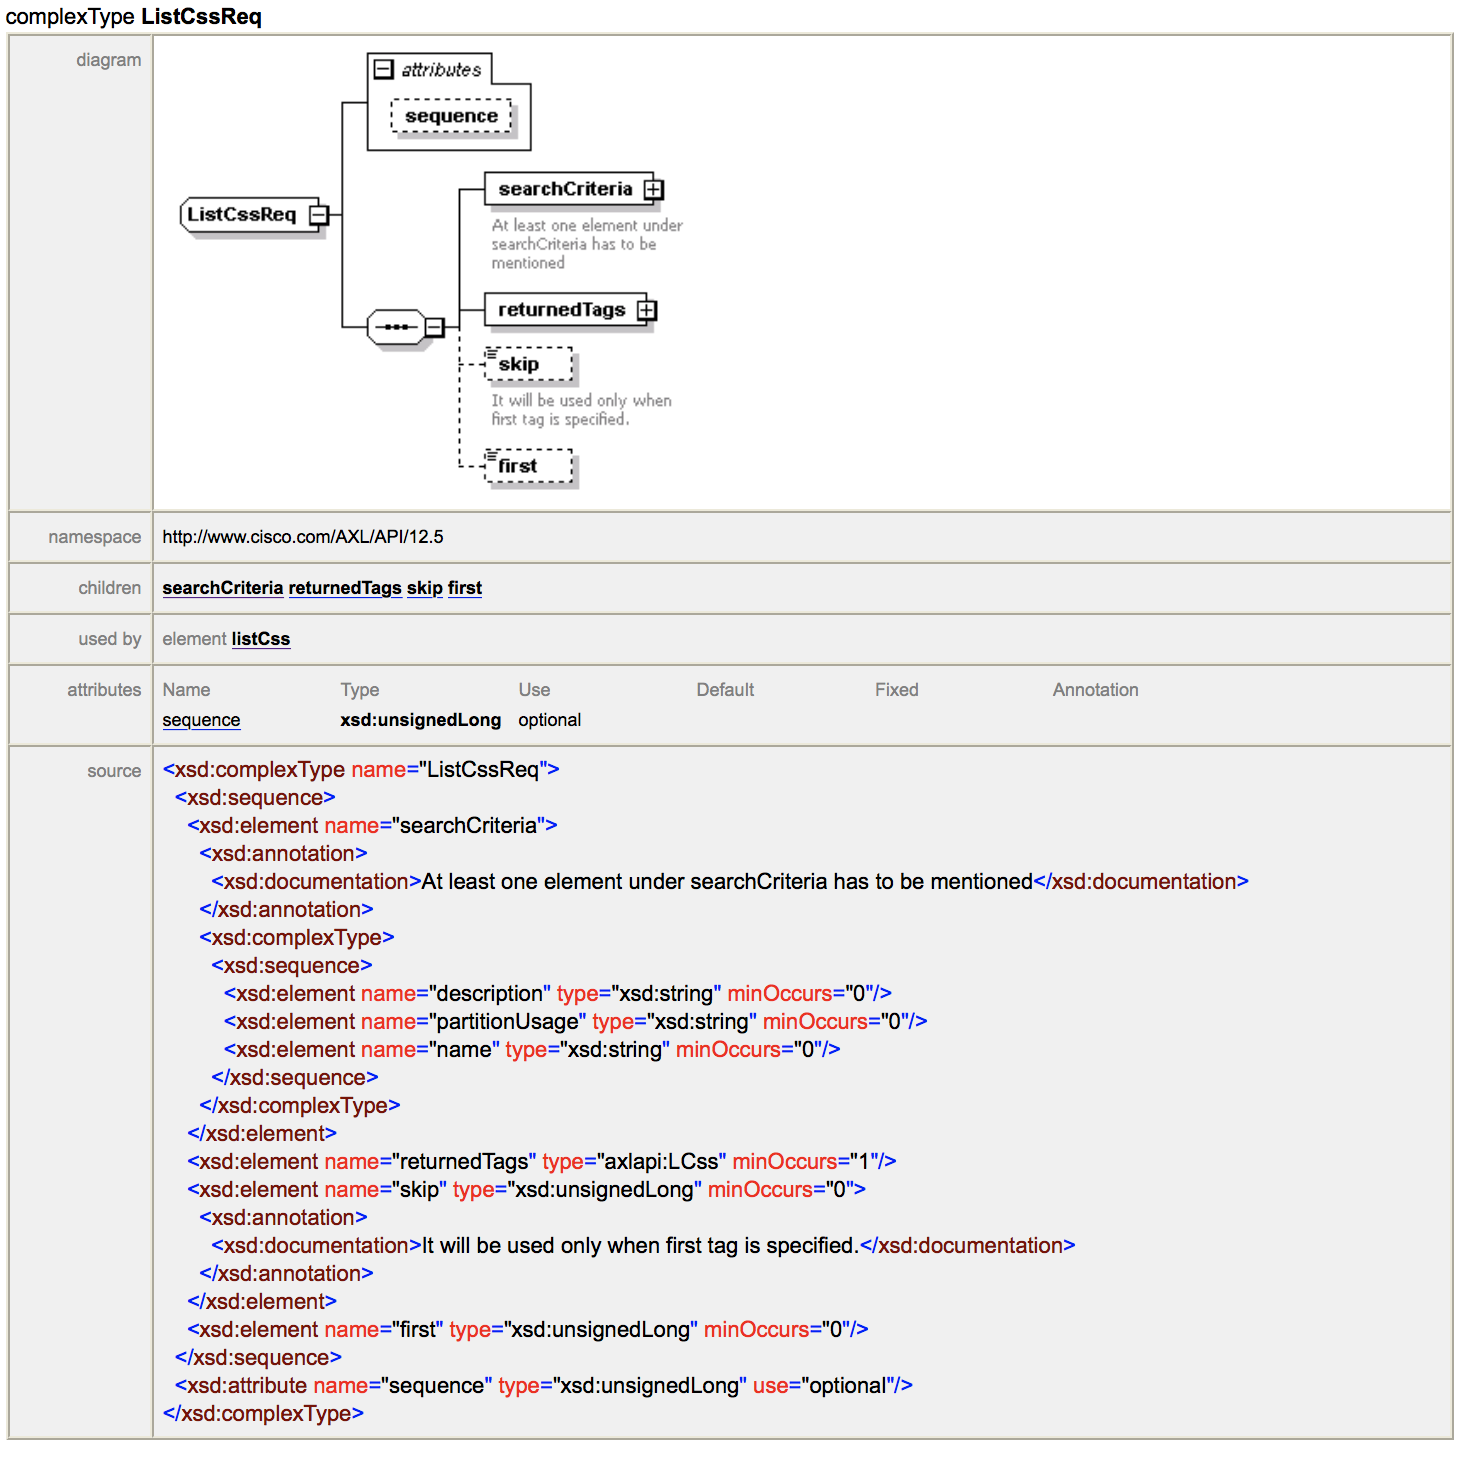
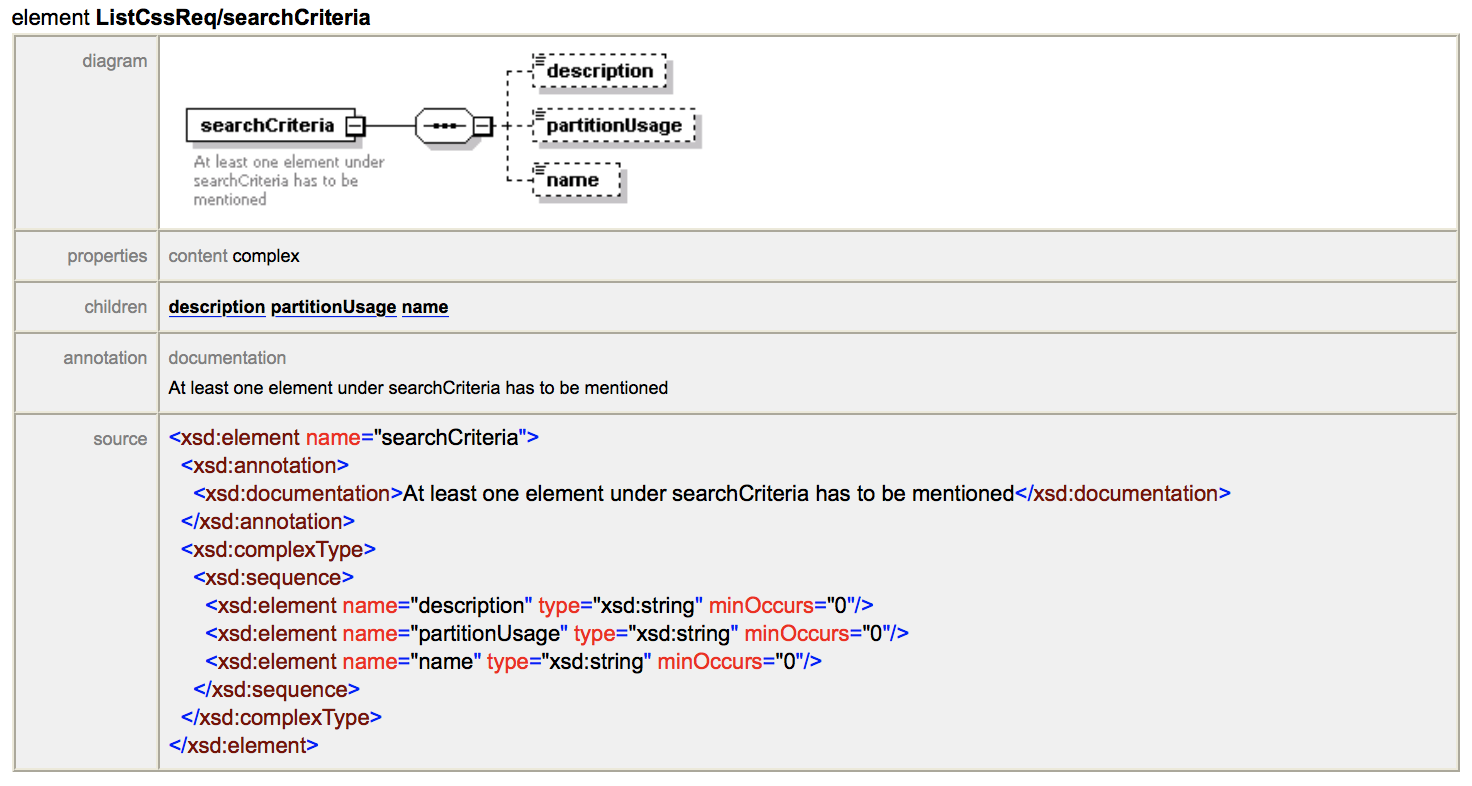
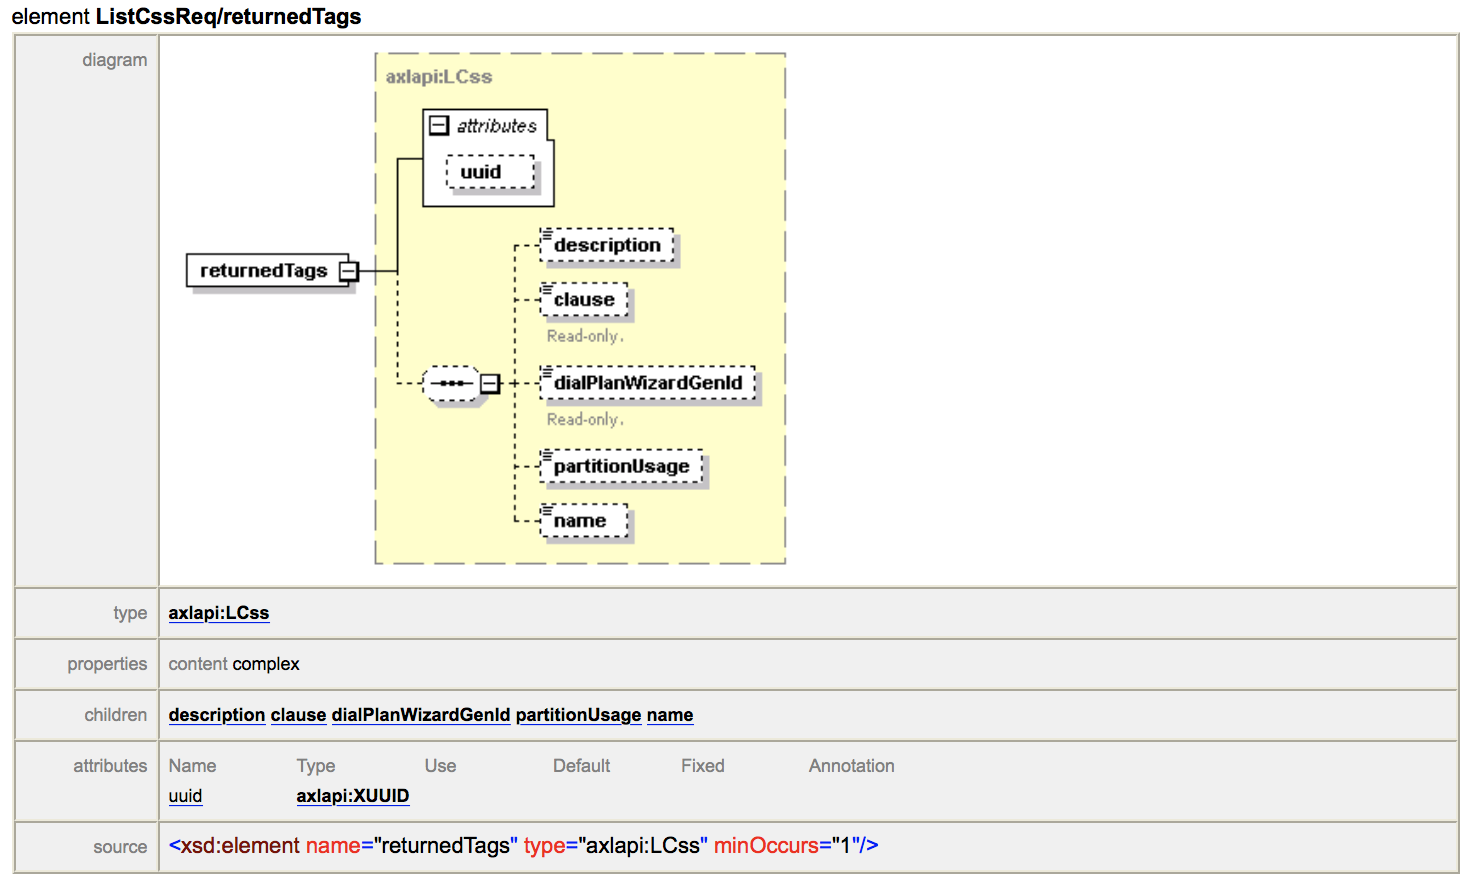

Both the `searchCriteria` and the `returnedTags` parameter can simply be passed as Python directories with the corresponding key/value mappings.

In [3]:
tags = 'name clause description dialPlanWizardGenId partitionUsage'

r = service.listCss(searchCriteria={'name':'%'}, returnedTags = {t:'' for t in tags.split()}, first=5)

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:listCss xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <searchCriteria>
out:        <name>%</name>
out:      </searchCriteria>
out:      <returnedTags>
out:        <description></description>
out:        <clause></clause>
out:        <dialPlanWizardGenId></dialPlanWizardGenId>
out:        <partitionUsage></partitionUsage>
out:        <name></name>
out:      </returnedTags>
out:      <first>5</first>
out:    </ns0:listCss>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:listCssResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <css uuid="{04A1F495-55BF-C9E5-9228-14C8E3E3409F}">
in:          <description>SJC CoS internal</description>
in:          <clause>DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164</

In [5]:
css_list = r['return'].css
print(css_list)
print(type(css_list[0]))

[{
    'description': 'SJC CoS internal',
    'clause': 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164',
    'dialPlanWizardGenId': None,
    'partitionUsage': 'General',
    'name': 'SJCInternal',
    'uuid': '{04A1F495-55BF-C9E5-9228-14C8E3E3409F}'
}, {
    'description': 'SJC CoS National',
    'clause': 'DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI',
    'dialPlanWizardGenId': None,
    'partitionUsage': 'General',
    'name': 'SJCNational',
    'uuid': '{0892A0EF-22C7-84C2-F704-79F5EA6D32E2}'
}, {
    'description': 'RCD CoS International',
    'clause': 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called',
    'dialPlanWizardGenId': None,
    'partitionUsage': 'General',
    'name': 'RCDInternational',
    'uuid': '{0EA6A9D1-DFDA-2C65-70E9-6254DFC03814}'
}, {
    'description': 'PSTN Rerouting',
    'clause': 'PSTNInternational',
    

Attributes of the returned objects can be accessed as attributes because zeep creates class instances based on the class definitions in the WSDL file (see `<class 'zeep.objects.LCss'>` above)

In [5]:
print('\n\n'.join(f'{css.name}({css.uuid}): {css.clause}' for css in css_list))

SJCInternal({04A1F495-55BF-C9E5-9228-14C8E3E3409F}): DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164

SJCNational({0892A0EF-22C7-84C2-F704-79F5EA6D32E2}): DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI

RCDInternational({0EA6A9D1-DFDA-2C65-70E9-6254DFC03814}): DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called

PSTNReroute({158E5D76-3F81-07CF-63BA-2200AE381A87}): PSTNInternational

RCDInternal({16F3FB0F-C231-8ED8-6384-9A095A93A32D}): DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164


In [6]:
# thanks to the history plugin we still have access to the actual request/reponse sent/received
print('SOAP Request sent to UCM:')
print(etree.tostring(history.last_sent['envelope'], pretty_print=True).decode())
print('\nSOAP Response received from UCM:')
print(etree.tostring(history.last_received['envelope'], pretty_print=True).decode())

SOAP Request sent to UCM:
<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
  <soap-env:Body>
    <ns0:listCss xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
      <searchCriteria>
        <name>%</name>
      </searchCriteria>
      <returnedTags>
        <description></description>
        <clause></clause>
        <dialPlanWizardGenId></dialPlanWizardGenId>
        <partitionUsage></partitionUsage>
        <name></name>
      </returnedTags>
      <first>5</first>
    </ns0:listCss>
  </soap-env:Body>
</soap-env:Envelope>


SOAP Response received from UCM:
<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
  <soapenv:Body>
    <ns:listCssResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
      <return>
        <css uuid="{04A1F495-55BF-C9E5-9228-14C8E3E3409F}">
          <description>SJC CoS internal</description>
          <clause>DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164</clause>
          <dialPlanW

# Executing SQL Queries

The [database dictionary](https://developer.cisco.com/docs/axl/#!12-5-cucm-data-dictionary) describes all tables in the UCM database and the relations between these tables.

The [executeSQLQuery](https://pubhub.devnetcloud.com/media/axl-schema-reference/docs/Files/AXLSoap_executeSQLQuery.html#Link45E) and [updateSQLQuery](https://pubhub.devnetcloud.com/media/axl-schema-reference/docs/Files/AXLSoap_executeSQLUpdate.html#Link466) methods enable direct access to the UCM database.

In [6]:
r = service.executeSQLQuery(sql='select * from processnode')

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select * from processnode</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <pkid>00000000-1111-0000-0000-000000000000</pkid>
in:          <name>EnterpriseWideData</name>
in:          <mac/>
in:          <systemnode>t</systemnode>
in:          <description/>
in:          <isactive>t</isactive>
in:          <nodeid>1</nodeid>
in:          <tknodeusage>1</tknodeusage>
in:          <ipv6name/>
in:          <fklbmhubgroup/>
in:          <tkprocessnoderole>1</tkprocessnoderole>
in:          <tkssomode>0</tkssomode>
in:        </row>
in:   

In [7]:
rows = r['return'].row
rows

[[<Element pkid at 0x1121d3820>,
  <Element name at 0x1121d3870>,
  <Element mac at 0x1121d38c0>,
  <Element systemnode at 0x1121d3910>,
  <Element description at 0x1121d3960>,
  <Element isactive at 0x1121d39b0>,
  <Element nodeid at 0x1121d3a00>,
  <Element tknodeusage at 0x1121d3a50>,
  <Element ipv6name at 0x1121d3aa0>,
  <Element fklbmhubgroup at 0x1121d3af0>,
  <Element tkprocessnoderole at 0x1121d3b40>,
  <Element tkssomode at 0x1121d3b90>],
 [<Element pkid at 0x1121d3be0>,
  <Element name at 0x1121d3c30>,
  <Element mac at 0x1121d3c80>,
  <Element systemnode at 0x1121d3cd0>,
  <Element description at 0x1121d3d20>,
  <Element isactive at 0x1121d3d70>,
  <Element nodeid at 0x1121d3dc0>,
  <Element tknodeusage at 0x1121d3e10>,
  <Element ipv6name at 0x1121d3e60>,
  <Element fklbmhubgroup at 0x1121d3eb0>,
  <Element tkprocessnoderole at 0x1121d3f00>,
  <Element tkssomode at 0x1121d3f50>],
 [<Element pkid at 0x1121d3fa0>,
  <Element name at 0x1121d7050>,
  <Element mac at 0x1121d70a

Not very helpful. We'd prefer to have a list of objects which allow to access the returned values as attributes

In [4]:
class Row:
    # Helper class to create an object based on a row returned from an AXL executeSqlQuery
    def __init__(self, row):
        # save a dictionary of key/value pairs
        self._obj =  {e.tag:e.text for e in row}

    def __repr__(self):
        """
        String representation for row object
        :return:
        """
        return f'Row({", ".join(f"{k}={v}" for k,v in self._obj.items())})'

    def __getattr__(self, item):
        """
        Satisfy attribute access by accessing saved directory
        :param item:
        :return:
        """
        return self._obj[item]

In [8]:
rows = [Row(r) for r in rows]

The `Row` helper class also allows us to access the values in the rows as attributes.

In [9]:
names = [r.name for r in rows]
names

['EnterpriseWideData',
 'us-cm-tftp1.ent-pa.com',
 'us-imp-sub1.ent-pa.com',
 'us-cm-pub.ent-pa.com',
 'us-cm-sub2.ent-pa.com',
 'us-imp-pub.ent-pa.com',
 'us-cm-sub1.ent-pa.com']

... and the `__repr__` method implementation gives us a readable representation of the rows

In [12]:
print('\n'.join(str(r) for r in rows))

Row(pkid=00000000-1111-0000-0000-000000000000, name=EnterpriseWideData, mac=None, systemnode=t, description=None, isactive=t, nodeid=1, tknodeusage=1, ipv6name=None, fklbmhubgroup=None, tkprocessnoderole=1, tkssomode=0)
Row(pkid=0c083472-2718-e161-5ce2-0bdf2fd08a27, name=us-cm-tftp1.ent-pa.com, mac=None, systemnode=f, description=None, isactive=t, nodeid=7, tknodeusage=1, ipv6name=None, fklbmhubgroup=None, tkprocessnoderole=1, tkssomode=2)
Row(pkid=3e49d44a-4608-cfb3-7f2e-9737c3076af4, name=us-imp-sub1.ent-pa.com, mac=None, systemnode=f, description=None, isactive=t, nodeid=5, tknodeusage=1, ipv6name=None, fklbmhubgroup=None, tkprocessnoderole=2, tkssomode=2)
Row(pkid=967433f9-cccf-4401-883d-b2eabd335cde, name=us-cm-pub.ent-pa.com, mac=None, systemnode=f, description=None, isactive=t, nodeid=2, tknodeusage=0, ipv6name=None, fklbmhubgroup=None, tkprocessnoderole=1, tkssomode=2)
Row(pkid=aef3530b-6588-08cd-3bc5-3582cf5550ad, name=us-cm-sub2.ent-pa.com, mac=None, systemnode=f, description

Here's how we could get a list of CSSes using thin AXL. This is (more or less) equivalent to the listCss above.

In [13]:
r = service.executeSQLQuery(sql='select name,clause from callingsearchspace')
rows = [Row(r) for r in r['return'].row]

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select name,clause from callingsearchspace</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <name>SJCInternal</name>
in:          <clause>DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164</clause>
in:        </row>
in:        <row>
in:          <name>SJCNational</name>
in:          <clause>DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI</clause>
in:        </row>
in:        <row>
in:          <name>RCDInternational</name>
in:          <clause>DN:Directory URI:URI:ESN:SparkCal

In [14]:
print(rows)

[Row(name=SJCInternal, clause=DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164), Row(name=SJCNational, clause=DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI), Row(name=RCDInternational, clause=DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called), Row(name=PSTNReroute, clause=PSTNInternational), Row(name=RCDInternal, clause=DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164), Row(name=RTPInternational, clause=DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RTPIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called), Row(name=RCDLocal, clause=DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:RCDPSTNLocal), Row(name=Enterprise_CSS, clause=DN), Row(name=DN, clause=DN), Row(name=SJCPhLocalize, clause=USPhLocalize:SJCPhLocalize), Row(name=ICTInbound, clause=ESN:SparkCall:Directory URI:URI:DN), Row(

Using simple thin AXL request we can easily execute some validations on the configured CSSes

For example: **Are there any CSSes without partitions assigned to them?**

In [15]:
csses_wo_partitions = [css.name for css in rows if css.clause is None]
print(f'CSSes w/o partitions: {", ".join(csses_wo_partitions)}')

CSSes w/o partitions: Block_All, CloudSIPURI


.. or: **Are there partitions which are not used in any CSS?**

In [16]:
import itertools

# let's try to determine the set of partitions used in CSSes
clauses = [r.clause for r in rows]
clauses

['DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164',
 'DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called',
 'PSTNInternational',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RTPIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:RCDPSTNLocal',
 'DN',
 'DN',
 'USPhLocalize:SJCPhLocalize',
 'ESN:SparkCall:Directory URI:URI:DN',
 'USemergency',
 'DN:ESN:URI:onNetRemote:Directory URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164:SJCPSTNLocal',
 'DN:Directory URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RTPIntra:UStoE164:RTPPSTNLocal',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:USto

In [17]:
# only not empty clauses
clauses = [c for c in clauses if c is not None]
clauses

['DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164',
 'DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called',
 'PSTNInternational',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RTPIntra:UStoE164:PSTNInternational:USPSTNNational:B2B_URI:edge nearest to the called',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:UStoE164:RCDPSTNLocal',
 'DN',
 'DN',
 'USPhLocalize:SJCPhLocalize',
 'ESN:SparkCall:Directory URI:URI:DN',
 'USemergency',
 'DN:ESN:URI:onNetRemote:Directory URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164:SJCPSTNLocal',
 'DN:Directory URI',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RTPIntra:UStoE164:RTPPSTNLocal',
 'DN:Directory URI:URI:ESN:SparkCall:onNetRemote:RCDIntra:USto

In [18]:
# get partition names by splitting at ':'
# this creates a list of lists of strings
clauses = [c.split(':') for c in clauses]
clauses

[['DN',
  'Directory URI',
  'URI',
  'ESN',
  'SparkCall',
  'onNetRemote',
  'SJCIntra',
  'UStoE164'],
 ['DN',
  'Directory URI',
  'ESN',
  'SparkCall',
  'SJCIntra',
  'USPSTNNational',
  'USemergency',
  'UStoE164',
  'onNetRemote',
  'URI'],
 ['DN',
  'Directory URI',
  'URI',
  'ESN',
  'SparkCall',
  'onNetRemote',
  'RCDIntra',
  'UStoE164',
  'PSTNInternational',
  'USPSTNNational',
  'B2B_URI',
  'edge nearest to the called'],
 ['PSTNInternational'],
 ['DN',
  'Directory URI',
  'URI',
  'ESN',
  'SparkCall',
  'onNetRemote',
  'RCDIntra',
  'UStoE164'],
 ['DN',
  'Directory URI',
  'URI',
  'ESN',
  'SparkCall',
  'onNetRemote',
  'RTPIntra',
  'UStoE164',
  'PSTNInternational',
  'USPSTNNational',
  'B2B_URI',
  'edge nearest to the called'],
 ['DN',
  'Directory URI',
  'URI',
  'ESN',
  'SparkCall',
  'onNetRemote',
  'RCDIntra',
  'UStoE164',
  'RCDPSTNLocal'],
 ['DN'],
 ['DN'],
 ['USPhLocalize', 'SJCPhLocalize'],
 ['ESN', 'SparkCall', 'Directory URI', 'URI', 'DN'],
 [

In [19]:
# now chain all partition names, put them in a set to make them unique
# also it's fast to check whether a partition is in the set
used_partitions = set(itertools.chain.from_iterable(clauses))
used_partitions

{'B2B_URI',
 'DN',
 'Directory URI',
 'ESN',
 'PSTNInternational',
 'RCDIntra',
 'RCDPSTNLocal',
 'RCDPhLocalize',
 'RTPIntra',
 'RTPPSTNLocal',
 'RTPPhLocalize',
 'SJCIntra',
 'SJCPSTNLocal',
 'SJCPhLocalize',
 'SparkCall',
 'URI',
 'USPSTNNational',
 'USPhLocalize',
 'USemergency',
 'UStoE164',
 'edge nearest to the called',
 'onNetRemote'}

In [20]:
# Get all partition names
r = service.executeSQLQuery(sql='select name from routepartition')
partition_names = [row[0].text for row in r['return'].row]
partition_names

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select name from routepartition</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <name>SJCIntra</name>
in:        </row>
in:        <row>
in:          <name>RTPIntra</name>
in:        </row>
in:        <row>
in:          <name>PSTNInternational</name>
in:        </row>
in:        <row>
in:          <name>USPhLocalize</name>
in:        </row>
in:        <row>
in:          <name>Global Learned E164 Numbers</name>
in:        </row>
in:        <row>
in:          <name>SJCPSTNLocal</name>
in:        </row>
in:        <row>
in:          <n

['SJCIntra',
 'RTPIntra',
 'PSTNInternational',
 'USPhLocalize',
 'Global Learned E164 Numbers',
 'SJCPSTNLocal',
 'RCDIntra',
 'RTPPSTNLocal',
 'Auto-registration_Pt',
 'URI',
 'ent-pacom',
 'loopavoidance',
 'B2B_URI',
 'Global Learned Enterprise Patterns',
 'DN',
 'Global Learned Enterprise Numbers',
 'RCDPSTNLocal',
 'Global Learned E164 Patterns',
 'onNetRemote',
 'SparkCall',
 'UStoE164',
 'Directory URI',
 'SJCPhLocalize',
 'RTPPhLocalize',
 'edge nearest to the called',
 'RCDPhLocalize',
 'USemergency',
 'USPSTNNational',
 'ESN',
 'Webex_Calling',
 'blockmobile']

In [21]:
# are there any partitions which are not used in any CSS?
unused_partitions = [p for p in partition_names if p not in used_partitions]
print(f'Partitions not used in any CSS: {", ".join(unused_partitions)}')

Partitions not used in any CSS: Global Learned E164 Numbers, Auto-registration_Pt, ent-pacom, loopavoidance, Global Learned Enterprise Patterns, Global Learned Enterprise Numbers, Global Learned E164 Patterns, Webex_Calling, blockmobile


In principle complex SQL statements can be used to execute more advanced queries. Multiple tables can be joined using the information published in the data dictionary:

## Table Relationships

**pkid** is the primary key ID. It is always of type GUID (a 36 character UUID).

Fields that begin with the letters "**fk**" represent foriegn keys into another table. The name of the field following the "fk" prefix up to but not including an underscore character is the name of the related table. The field in related table is always pkid. and is a GUID.

Fields that begin with the letters "**ik**" represent internal keys into the same table.

Fields that begin with a "**tk**" represent an enumerated type. This field is related to a table whose name begins with "Type" and ends with the name of the field following the prefix up to but not including an underscore character. The field in the related table is always "enum" and is an integer.


Using this information this SQL query combines the `numplan` and `typepatternusage` tables and selects a list of directory numbers starting with +1919 in ascending order:
```
select dnorpattern from numplan np left join typepatternusage tpu on np.tkpatternusage=tpu.enum where tpu.name="Device" and dnorpattern like "%+1919%" order by dnorpattern
```

In [22]:
r = service.executeSQLQuery('select dnorpattern,tkpatternusage from numplan np left join typepatternusage tpu on np.tkpatternusage=tpu.enum where tpu.name="Device" and dnorpattern like "%+1919%" order by dnorpattern')

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select dnorpattern,tkpatternusage from numplan np left join typepatternusage tpu on np.tkpatternusage=tpu.enum where tpu.name="Device" and dnorpattern like "%+1919%" order by dnorpattern</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <dnorpattern>\+19195551000</dnorpattern>
in:          <tkpatternusage>2</tkpatternusage>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551001</dnorpattern>
in:          <tkpatternusage>2</tkpatternusage>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551002</d

In [23]:
if r['return'] is None:
    print('No matching DNs found')
else:
    dns = [r[0].text for r in r['return'].row]
    print(dns)

['\\+19195551000', '\\+19195551001', '\\+19195551002', '\\+19195551003', '\\+19195551004', '\\+19195551005', '\\+19195551006', '\\+19195551007', '\\+19195551008', '\\+19195551009', '\\+19195551010', '\\+19195551011', '\\+19195551011', '\\+19195551012', '\\+19195551013', '\\+19195551014', '\\+19195551015', '\\+19195551016', '\\+19195551017', '\\+19195551018', '\\+19195551018', '\\+19195551019', '\\+19195551020', '\\+19195551021', '\\+19195551022', '\\+19195551023', '\\+19195551024', '\\+19195551026', '\\+19195551027', '\\+19195551028', '\\+19195551029', '\\+19195551030', '\\+19195551031', '\\+19195551032', '\\+19195551033', '\\+19195551034', '\\+19195551035', '\\+19195551036', '\\+19195551037', '\\+19195551038', '\\+19195551039', '\\+19195551040', '\\+19195551041', '\\+19195551042', '\\+19195551043', '\\+19195551044', '\\+19195551045', '\\+19195551046', '\\+19195551047', '\\+19195551048', '\\+19195551049', '\\+19195551050', '\\+19195551051', '\\+19195551052', '\\+19195551053', '\\+19195

Knowing the enum for DNs the above query obviously could also have been simplified to only using the numplan table .. and no join.

In [24]:
r = service.executeSQLQuery(('select dnorpattern from numplan '
                             'where tkpatternusage=2 and '
                             'dnorpattern like "%+1919%" '
                             'order by dnorpattern'))

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select dnorpattern from numplan where tkpatternusage=2 and dnorpattern like "%+1919%" order by dnorpattern</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <dnorpattern>\+19195551000</dnorpattern>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551001</dnorpattern>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551002</dnorpattern>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551003</dnorpattern>
in:        </row>
in:        <row>
in:          <dnorpattern>\+19195551004<

In [25]:
if r['return'] is None:
    print('No matching DNs found')
else:
    dns = [r[0].text for r in r['return'].row]
    print(dns)

['\\+19195551000', '\\+19195551001', '\\+19195551002', '\\+19195551003', '\\+19195551004', '\\+19195551005', '\\+19195551006', '\\+19195551007', '\\+19195551008', '\\+19195551009', '\\+19195551010', '\\+19195551011', '\\+19195551011', '\\+19195551012', '\\+19195551013', '\\+19195551014', '\\+19195551015', '\\+19195551016', '\\+19195551017', '\\+19195551018', '\\+19195551018', '\\+19195551019', '\\+19195551020', '\\+19195551021', '\\+19195551022', '\\+19195551023', '\\+19195551024', '\\+19195551026', '\\+19195551027', '\\+19195551028', '\\+19195551029', '\\+19195551030', '\\+19195551031', '\\+19195551032', '\\+19195551033', '\\+19195551034', '\\+19195551035', '\\+19195551036', '\\+19195551037', '\\+19195551038', '\\+19195551039', '\\+19195551040', '\\+19195551041', '\\+19195551042', '\\+19195551043', '\\+19195551044', '\\+19195551045', '\\+19195551046', '\\+19195551047', '\\+19195551048', '\\+19195551049', '\\+19195551050', '\\+19195551051', '\\+19195551052', '\\+19195551053', '\\+19195

### Getting device counts per device type

In [26]:
r = service.executeSQLQuery(('select count(d.name) c, tm.name from device d '
                             'inner join typemodel tm on d.tkmodel=tm.enum '
                             'where tm.tkclass=1 '
                             'group by tm.name '
                             'order by tm.name'))

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select count(d.name) c, tm.name from device d inner join typemodel tm on d.tkmodel=tm.enum where tm.tkclass=1 group by tm.name order by tm.name</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <c>11</c>
in:          <name>CTI Port</name>
in:        </row>
in:        <row>
in:          <c>34</c>
in:          <name>CTI Remote Device</name>
in:        </row>
in:        <row>
in:          <c>4</c>
in:          <name>Cisco 7821</name>
in:        </row>
in:        <row>
in:          <c>1</c>
in:          <name>Cisco 7861</name>
in:        

In [27]:
rows = [Row(r) for r in r['return'].row]
max_name = max(len(r.name) for r in rows)
print('\n'.join(f'{r.name:{max_name}} : {r.c}' for r in rows))

CTI Port                                : 11
CTI Remote Device                       : 34
Cisco 7821                              : 4
Cisco 7861                              : 1
Cisco 7960                              : 2
Cisco 7962                              : 1
Cisco 7965                              : 2
Cisco 7971                              : 1
Cisco 7975                              : 1
Cisco 8811                              : 3
Cisco 8821                              : 2
Cisco 8831                              : 3
Cisco 8832                              : 3
Cisco 8841                              : 3
Cisco 8845                              : 13
Cisco 8851                              : 3
Cisco 8861                              : 3
Cisco 8865                              : 17
Cisco 8945                              : 2
Cisco 8961                              : 1
Cisco 9951                              : 4
Cisco 9971                              : 22
Cisco ATA 190              

### Device counts per device pool and device type

In [28]:
r = service.executeSQLQuery(('select count(d.name) c, dp.name dpname, tm.name from device d '
                             'inner join typemodel tm on d.tkmodel=tm.enum '
                             'inner join devicepool dp on d.fkdevicepool=dp.pkid '
                             'where tm.tkclass=1 '
                             'group by dpname, tm.name '
                             'order by dpname, tm.name'))

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:executeSQLQuery xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <sql>select count(d.name) c, dp.name dpname, tm.name from device d inner join typemodel tm on d.tkmodel=tm.enum inner join devicepool dp on d.fkdevicepool=dp.pkid where tm.tkclass=1 group by dpname, tm.name order by dpname, tm.name</sql>
out:    </ns0:executeSQLQuery>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:executeSQLQueryResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <row>
in:          <c>1</c>
in:          <dpname>Default</dpname>
in:          <name>CTI Remote Device</name>
in:        </row>
in:        <row>
in:          <c>1</c>
in:          <dpname>Default</dpname>
in:          <name>Cisco 8811</name>
in:        </row>
in:        <row>
in:  

In [29]:
rows = [Row(r) for r in r['return'].row]
max_name = max(len(r.name) for r in rows)
max_dp = max(len(r.dpname) for r in rows)
print('\n'.join(f'{r.dpname:{max_dp}}/{r.name:{max_name}} : {r.c}' for r in rows))

Default                                         /CTI Remote Device                       : 1
Default                                         /Cisco 8811                              : 1
Default                                         /Cisco 8845                              : 3
Default                                         /Cisco DX650                             : 1
Default                                         /Cisco TelePresence DX70                 : 1
Default                                         /Universal Device Template               : 2
RB1_Video_20MB                                  /Cisco DX650                             : 1
RB1_Video_encryptedSRST_20MB                    /Cisco 7975                              : 1
RB1_Video_encryptedSRST_20MB                    /Cisco 8865                              : 2
RB1_Video_encryptedSRST_20MB                    /Cisco 9971                              : 1
RB1_Video_encryptedSRST_20MB                    /Cisco DX650          

### More SQL Queries

More examples can be found here: https://www.cisco.com/c/en/us/support/docs/unified-communications/unified-communications-manager-callmanager/117726-technote-cucm-00.html

# Adding Users

In [30]:
# list some users
r = service.listUser(searchCriteria={'lastName':'%'}, returnedTags={'userid':''}, first=10)
user_list = r['return'].user
print(user_list) 

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:listUser xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <searchCriteria>
out:        <lastName>%</lastName>
out:      </searchCriteria>
out:      <returnedTags>
out:        <userid></userid>
out:      </returnedTags>
out:      <first>10</first>
out:    </ns0:listUser>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:listUserResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <user uuid="{01159FCB-206F-3E99-331D-1E912AE45D8B}">
in:          <userid>nwheeler</userid>
in:        </user>
in:        <user uuid="{0137B722-B4BD-4926-E4E8-D4A8A12B413E}">
in:          <userid>nmcdonal</userid>
in:        </user>
in:        <user uuid="{013F34E9-D7AE-6FFD-D60A-755405FCD9DF}">
in:          <userid>bharrell</userid>
in:        </use

In [31]:
# get details of 1st user
user = user_list[0]
rt = 'firstName lastName userid presenceGroupName'
r = service.getUser(uuid=user.uuid, returnedTags={t:'' for t in rt.split()})
user_details = r['return'].user
print('\n'.join(f'{t}={user_details[t]}' for t in rt.split()))

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:getUser xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <uuid>{01159FCB-206F-3E99-331D-1E912AE45D8B}</uuid>
out:      <returnedTags>
out:        <firstName></firstName>
out:        <lastName></lastName>
out:        <userid></userid>
out:        <presenceGroupName></presenceGroupName>
out:      </returnedTags>
out:    </ns0:getUser>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:getUserResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>
in:        <user uuid="{01159FCB-206F-3E99-331D-1E912AE45D8B}">
in:          <firstName>Naomi</firstName>
in:          <displayName>Naomi Wheeler</displayName>
in:          <lastName>Wheeler</lastName>
in:          <userid>nwheeler</userid>
in:          <presenceGroupName uuid="{AD243D17-98B4-4118-8

In [32]:
# create a user object based on the type definition in the WSDL
factory = client.type_factory('ns0')
new_user = factory.XUser(
    firstName='Bob',
    lastName='Barnaby',
    userid='bbarnaby',
    presenceGroupName='Standard Presence group',
    # associated groups is a list of userGroup elements. Each userGroup has a name
    associatedGroups={
        'userGroup': [
            {'name': 'Standard CCM End Users'},
            {'name': 'Standard CTI Enabled'}
        ]
    }
)


Now try to add the user using the [addUser](https://pubhub.devnetcloud.com/media/axl-schema-reference/docs/Files/AXLSoap_AddUserReq.html#Link1EB) method

In [33]:
r = service.addUser(user=new_user)

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:addUser xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <user>
out:        <firstName>Bob</firstName>
out:        <lastName>Barnaby</lastName>
out:        <userid>bbarnaby</userid>
out:        <associatedGroups>
out:          <userGroup>
out:            <name>Standard CCM End Users</name>
out:          </userGroup>
out:          <userGroup>
out:            <name>Standard CTI Enabled</name>
out:          </userGroup>
out:        </associatedGroups>
out:        <presenceGroupName>Standard Presence group</presenceGroupName>
out:      </user>
out:    </ns0:addUser>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <ns:addUserResponse xmlns:ns="http://www.cisco.com/AXL/API/11.5">
in:      <return>{376A38CD-BC4C-A698-BF25-D2D621494E6F}</return>
in:    </ns:addUser

In [34]:
new_user_uuid=r['return']
new_user_uuid

'{376A38CD-BC4C-A698-BF25-D2D621494E6F}'

We successfully added a user using AXL. Verify the success by checking the endusers on UCM.

# AXL Errors

Let's try to add the same(!) user again and see what happens...


In [35]:
r = service.addUser(user=new_user)

out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:addUser xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <user>
out:        <firstName>Bob</firstName>
out:        <lastName>Barnaby</lastName>
out:        <userid>bbarnaby</userid>
out:        <associatedGroups>
out:          <userGroup>
out:            <name>Standard CCM End Users</name>
out:          </userGroup>
out:          <userGroup>
out:            <name>Standard CTI Enabled</name>
out:          </userGroup>
out:        </associatedGroups>
out:        <presenceGroupName>Standard Presence group</presenceGroupName>
out:      </user>
out:    </ns0:addUser>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <soapenv:Fault>
in:      <faultcode>soapenv:Client</faultcode>
in:      <faultstring>Could not insert new row - duplicate value in a UNIQUE INDEX colu

Fault: Could not insert new row - duplicate value in a UNIQUE INDEX column (Unique Index:).

The SOAP response clearly shows that the same user can not be added twice. Zeep raised an exception after receiving the soapenv:Fault. 

Python allows us to intercept exceptions and gracefully act on them

In [36]:
try:
    r = service.addUser(user=new_user)
except zeep.exceptions.Fault as fault:
    # catch zeep exception. The Fault object has the AXL errors message and the detail element
    # from which we can extract the integer AXL error code
    axl_code = int(fault.detail.find('.//axlcode').text)
    print(f"Failed to insert user: {axl_code}/{fault.message}")
else:
    print(f'Successfully added user. UUID: {r["return"]}')


out:<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/">
out:  <soap-env:Body>
out:    <ns0:addUser xmlns:ns0="http://www.cisco.com/AXL/API/11.5">
out:      <user>
out:        <firstName>Bob</firstName>
out:        <lastName>Barnaby</lastName>
out:        <userid>bbarnaby</userid>
out:        <associatedGroups>
out:          <userGroup>
out:            <name>Standard CCM End Users</name>
out:          </userGroup>
out:          <userGroup>
out:            <name>Standard CTI Enabled</name>
out:          </userGroup>
out:        </associatedGroups>
out:        <presenceGroupName>Standard Presence group</presenceGroupName>
out:      </user>
out:    </ns0:addUser>
out:  </soap-env:Body>
out:</soap-env:Envelope>
in:<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
in:  <soapenv:Body>
in:    <soapenv:Fault>
in:      <faultcode>soapenv:Client</faultcode>
in:      <faultstring>Could not insert new row - duplicate value in a UNIQUE INDEX colu